#### Logistic Regression

We won’t go into the details in this course, but in short, instead of minimizing the least squares, logistic regressions minimize the cross-entropy (CE) loss function that we can derive by computing the maximum likelihood estimation (MLE).

**Iris dataset**

We will use the iris dataset to illustrate logistic regressions. It’s a set of 150 petal/sepal width and length measurements from iris flowers of three different types: setosa, versicolor and virginica.

We can load it using the load_iris() function from the Scikit-learn datasets module.

In [1]:
from sklearn import datasets

# Load dataset
iris = datasets.load_iris()

print("Type:", type(iris))  # sklearn.utils.Bunch

Type: <class 'sklearn.utils.Bunch'>


In [2]:
# Inspect object
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

The dictionary has five entries

* data - the input matrix
* target - the target vector
* target_names - the name of the categories
* DESCR - a description of the dataset
* feature_names - the name of the features

Let’s take a look at the feature names

In [3]:
# Get feature names
iris.feature_names

['sepal length (cm)',
 'sepal width (cm)',
 'petal length (cm)',
 'petal width (cm)']

There are four features in total. Each one corresponds to a column in the data input matrix. The target values are encoded with numbers between 0 and 2. Let’s count the number of values in each category

In [4]:
import pandas as pd

# Category distribution
pd.value_counts(iris["target"])


0    50
1    50
2    50
dtype: int64

There are 50 flowers per type. These numerical labels correspond to the indexes of the target names in the target_names list

In [5]:
# Categories
print("Target names:", iris.target_names)

Target names: ['setosa' 'versicolor' 'virginica']


In this unit, we will create a binary classifier that recognizes setosa flowers. Hence, we need to create a target vector y that encodes positive entries (setosa) with ones and negative entries (versicolor and virginica) with zeros



In [6]:
# Create the binary target vector
y = (iris["target"] == 0).astype(int)

In this code, we create an array of boolean values where True denotes the positive class and False the negative one. We then convert the boolean values into zeros and ones using the astype(int) function.

In this example, we will only work with the petal features, i.e., petal width and petal length. They correspond to the columns with indices 2 and 3 according to the feature_names list from above. Let’s create the input matrix

In [7]:
# Create the input matrix
X = iris["data"]  # Get matrix with all features
X = X[:, [2, 3]]  # Keep only petal features

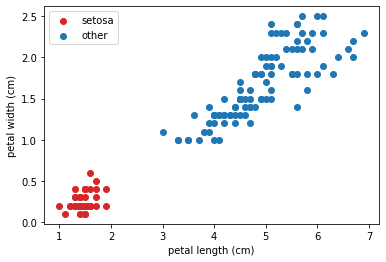

In [8]:
# Finally, let’s plot our X and y values.
%matplotlib inline
import matplotlib.pyplot as plt

# Plot data points
setosa_idx = y == 1  # setosa data points

plt.scatter(
    X[:, 0][setosa_idx], X[:, 1][setosa_idx], color="C3", label="setosa"
)  # Setosa
plt.scatter(
    X[:, 0][~setosa_idx], X[:, 1][~setosa_idx], color="C0", label="other"
)  # Versicolor and virginica

# Set labels
plt.xlabel("petal length (cm)")
plt.ylabel("petal width (cm)")
plt.legend()
plt.show()


In this code, we create a setosa_idx list where True entries correspond to setosa flowers. We can then use this list of booleans to separate and plot the two categories with different colors.

As we can see, there is a clear separation between the two classes. In this case, we say that the data is linearly separable because it’s possible to draw a line (or a hyperplane in higher dimensions) that separates the different categories.

Let’s see how to separate these two classes using logistic regressions.

### Scikit-learn implementation
Let’s start by splitting the data into train/test splits

In [9]:
from sklearn.model_selection import train_test_split

# Split into train/test sets
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.3, random_state=0)

Scikit-learn implements a LogisticRegression object which follows the standard estimator API. To avoid any issue with the features scale, let’s encapsulate the estimator in a pipeline with a StandardScaler

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Create the estimator (within a pipeline for avoiding scaling issues)
logreg = make_pipeline(StandardScaler(), LogisticRegression()) 

# Fit it to train data
logreg.fit(X_tr, y_tr)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

In [12]:
# Create the estimator
logreg = make_pipeline(StandardScaler(), LogisticRegression(solver="liblinear"))

# Fit it to train data
logreg.fit(X_tr, y_tr)

# Accuracy on test set
accuracy = logreg.score(X_te, y_te)
print("Accuracy: {:.3f}".format(accuracy))

Accuracy: 1.000


We obtain a test accuracy of 1 which means that our estimator correctly classified all points from the test set. We can compute predictions for new data points with the predict() function



In [14]:
# New flower
new_flower = [
    1.5,  # petal length (cm)
    0.3,  # petal width (cm)
]

# Classify it
logreg.predict([new_flower])

array([1])

Our classifier labels the new data point with a one (positive class) which means that it’s likely a setosa flower. We can obtain the probabilities from the sigmoid with predict_proba()

In [15]:
# Get probabilities
logreg.predict_proba([new_flower])

array([[0.05238258, 0.94761742]])

The function returns the probability for each category. In our case, we get two probabilities. The first one corresponds to the negative class and the second one to the positive class. According to our classifier, the new data point is a setosa flower with probability 0.95.

Note that we can use this function to visualize the decision surface of our classifier and draw the boundary that delimits the two classes by marking points with p = 0.5 We provide a decision_surface(X, y, logreg) function in the annex. In short, the function creates a grid of data points in the range of our X/y values and evaluates their probability using our logreg estimator.



In [17]:
import numpy as np

# Helper function
def decision_surface(ax, X, y, logreg):
    # Plot data points
    setosa_idx = y == 1  # Setosa data points

    plt.scatter(
        X[:, 0][setosa_idx], X[:, 1][setosa_idx], color="C3", label="setosa"
    )  # Setosa
    plt.scatter(
        X[:, 0][~setosa_idx], X[:, 1][~setosa_idx], color="C0", label="other"
    )  # Versicolor and virginica

    # Create a grid of values
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    x_values = np.linspace(*xlim, num=40)
    y_values = np.linspace(*ylim, num=40)
    xx, yy = np.meshgrid(x_values, y_values)
    points = np.c_[xx.flatten(), yy.flatten()]

    # Probability for positive class (setosa)
    probs = logreg.predict_proba(points)
    prob_setosa = probs[:, 1]

    # Draw decision boundary (p=0.5)
    zz = prob_setosa.reshape(xx.shape)
    plt.contour(xx, yy, zz, levels=[0.5], colors="gray")

    # Plot decision surface with level curves
    plt.contourf(xx, yy, zz, 10, alpha=0.3, cmap=plt.cm.coolwarm)

    # Add labels
    plt.xlabel("petal length (cm)")
    plt.ylabel("petal width (cm)")
    plt.legend()
    plt.colorbar(label="probability")
    plt.show()

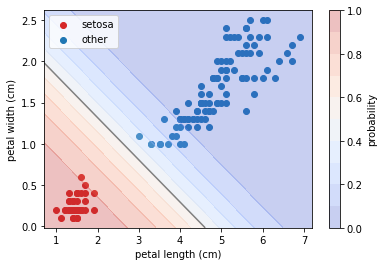

In [18]:
# Plot decision surface
fig = plt.figure()
decision_surface(fig.gca(), X, y, logreg)

We use a red/blue scale to plot the decision surface. Regions in red are associated with probabilities close to one and regions in blue with probabilities close to zero. The gray line delimits points with p < 0.5 from points with p > 0.5.